# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/MLDL_lab/hw4'

/content/drive/MyDrive/MLDL_lab/hw4


In [3]:
import math
import random
from pathlib import Path
import sys

from data.data import prepareData

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [181]:
"""
Discussed with: 강창훈(데이터사이언스학과)
"""


'\nDiscussed with: 강창훈(데이터사이언스학과)\n'

## Util

**Do NOT Modify** code blocks in this section

In [4]:
SEED = 1234
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
def train(model, iterator, optimizer, loss_fn, clip):    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)        
        optimizer.zero_grad()
        output = model(src, trg)
        loss = loss_fn(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip) 
        optimizer.step()        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [6]:
def evaluate(model, iterator, loss_fn):    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src = batch[0].to(DEVICE)
            trg = batch[1].to(DEVICE)
            output = model(src, trg)
            loss = loss_fn(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [7]:
def plot_history(history):
    plt.figure(figsize=(2 * 13, 4))
    plt.subplot(1, 5, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_PPL'], label="train_PPL")
    plt.plot(history['val_PPL'], label="val_PPL")
    plt.xlabel("iterations")
    plt.ylabel("PPL")
    plt.legend()
    plt.subplot(1, 5, 2)
    plt.title("Learning Rate")
    plt.plot(history['lr'], label="learning rate")
    plt.xlabel("iterations")
    plt.ylabel("LR")
    plt.show()

## Dataset & Dataloader

**Do NOT Modify** code blocks in this section

In [8]:
MAX_LENGTH = 10
BATCH_SIZE = 64

TRAIN_RATIO = 0.7 # train dataset ratio, should be a float in (0, 0.8]
VALID_RATIO = 0.8 - TRAIN_RATIO

SOS_token = 0
EOS_token = 1

In [9]:
class TranslateDataset(Dataset):
    def __init__(self, max_length=10, fra2eng=True):
        self.input_lang, self.output_lang, self.pairs = prepareData('eng', 'fra', max_length=max_length, reverse=fra2eng)
        self.max_length = max_length
        self.input_lang.addWord('PAD')
        self.output_lang.addWord('PAD')
        self.input_lang_pad = self.input_lang.word2index['PAD']
        self.output_lang_pad = self.output_lang.word2index['PAD']
        
        print("\n")
        print("This is data example")
        print(random.choice(self.pairs))

        print("\n")
        print("This is index of PAD token for each language")
        print(f"fra {self.output_lang.word2index['PAD']}")
        print(f"eng {self.input_lang.word2index['PAD']}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        x, y = self._tensorsFromPair(pair)
        return x, y

    def _tensorFromSentence(self, lang, sentence):
        indexes = [lang.word2index[word] for word in sentence.split(' ')]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

    def _tensorsFromPair(self, pair):
        input_tensor = self._tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self._tensorFromSentence(self.output_lang, pair[1])
        return (input_tensor, target_tensor)
    
    def collate_fn(self, data):
        x_batch = []; y_batch = []
        
        for x, y in data:
            if x.shape[0] < self.max_length-1:
                x = torch.cat([x, self.input_lang_pad*torch.ones((self.max_length-1 - x.shape[0], 1), dtype=x.dtype)])
            elif x.shape[0] > self.max_length-1:
                x = x[:self.max_length-1]
            if y.shape[0] < self.max_length-1:
                y = torch.cat([y, self.output_lang_pad*torch.ones((self.max_length-1 - y.shape[0], 1), dtype=y.dtype)])
            elif y.shape[0] > self.max_length-1:
                y = y[:self.max_length-1]

            x_batch.append(torch.cat([torch.tensor([SOS_token]), x.squeeze(1)]))
            y_batch.append(torch.cat([torch.tensor([SOS_token]), y.squeeze(1)]))
        
        return torch.stack(x_batch), torch.stack(y_batch)

dataset = TranslateDataset(max_length=MAX_LENGTH)

train_size = int(len(dataset)*TRAIN_RATIO)
valid_size = int(len(dataset)*VALID_RATIO)
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, len(dataset)-(train_size+valid_size)],)
print("\n")
print(f"This is dataset_size: {len(dataset)}")
print(f"train_size: {train_size}")
print(f"valid_data: {valid_size}")
print(f"test_data: {len(test_data)}")

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


This is data example
['tu me fais de l ombre .', 'you re blocking my light .']


This is index of PAD token for each language
fra 2803
eng 4345


This is dataset_size: 10599
train_size: 7419
valid_data: 1059
test_data: 2121


# 1. Seq2Seq model with Attention Mechanism

## Implement LSTM Seq2Seq Model

In [168]:
class LSTMEncoder(nn.Module):
    
    def __init__(self, in_dim, emb_dim, hid_dim):
        super(LSTMEncoder, self).__init__()
        
        self.embedding = nn.Embedding(in_dim, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)

    def forward(self, input, hidden, cell):
        '''
        Q2 - (a)
        Implement forward method of LSTM Encoder Module

        INPUT
        - input: input sentence, (B, max_len)
        - hidden: initialized hidden state, (1, B, hid_dim)
        - cell: initialized cell state, (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need. (e.g. hidden states of encoder, etc.)
        '''
        ################### YOUR CODE ###################
        input = self.embedding(input).to(DEVICE)
        hiddens, (_, _) = self.lstm(input, (hidden, cell))
        return hiddens
        #################################################

In [169]:
class AttnLSTMDecoder(nn.Module):

    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        super(AttnLSTMDecoder, self).__init__()
        self.enc_hiddens = enc_hiddens # encoder output
        self.dropout = dropout
        
        self.embedding = nn.Embedding(out_dim, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim + hid_dim, hid_dim)
        self.tanh = nn.Tanh()
        self.classifier = nn.Linear(hid_dim, out_dim)

    def forward(self, input, hidden, cell):
        
        '''
        Q2 - (a)
        Implement forward method of LSTM Decoder Module with dot-product attention
        Before implementing LSTM layer, make sure to feed the concatenated input into Linear and tanh activation layer.
        This will allow the concatenated input to be resized from (B, hid_dim + hid_dim) into (B, hid_dim) 

        INPUT
        - input: a token of input sentence (B, 1)
        - hidden: previous hidden state (B, hid_dim)
        - cell: previous cell state (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need.
        Some examples below
        - predicted token embedding (N, emb_dim)
        - current hidden state
        - current cell state
        '''

        ################### YOUR CODE ###################
        query = hidden # set query to calculate attention
        key = self.enc_hiddens.permute(1,0,2)
        value = self.enc_hiddens.permute(1,0,2)
        
        input = self.embedding(input)
        input = nn.Dropout(self.dropout)(input)

        attn_score = torch.matmul(key, query.permute(0,2,1))
        attn_coefficient = F.softmax(attn_score, dim=1)
        weighted_kv = (value * attn_coefficient)
        attn_value = torch.sum(weighted_kv, dim=1)

        hidden_concat = torch.cat([query, attn_value.unsqueeze(1)], dim=2)
        hidden_concat = self.fc(hidden_concat)
        hidden_concat = self.tanh(hidden_concat)
        hidden_concat = hidden_concat.permute(1,0,2)

        output, (h,c) = self.lstm(input, (hidden_concat, cell))
        output = self.classifier(output)
        output = F.log_softmax(output)

        return output, (h,c)
        #################################################

In [170]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(LSTMSeq2Seq, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = nn.Dropout(dropout)
        
        self.encoder = LSTMEncoder(in_dim, emb_dim, hid_dim)
        self.decoder = AttnLSTMDecoder(emb_dim, hid_dim, out_dim, dropout)
        
    def forward(self, src, trg):
        '''
        Q2 - (b)
        Implement forward method of LSTM Seq2Seq Module
        (Decoder module should attend encoder's outputs using dot product.)
        
        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        - output of one-hot prediction (B, out_dim, max_len)
        '''
        ################### YOUR CODE ###################
        batch_size, mx_len = src.shape
        # Encoder (start from zero-hidden & zero-cell states)
        h_e = torch.zeros(1, batch_size, self.hid_dim).to(self.device)
        c_e = torch.zeros(1, batch_size, self.hid_dim).to(self.device)
        hiddens = self.encoder(src, h_e, c_e).permute(1,0,2)

        # Decoder
        self.decoder.enc_hiddens = hiddens # set encoder's hidden states
        outputs = torch.zeros(mx_len, batch_size, dataset.output_lang.n_words).to(self.device) # to store each decoder's output
        h_d = hiddens[-1].unsqueeze(1).to(self.device)
        c_d = torch.zeros(1, batch_size, self.hid_dim).to(self.device)
        trg = trg.permute(1,0)
        for t in range(1, mx_len): # for each t'th token, get decoder outputs
            input = trg[t].unsqueeze(1)
            output, (h, c) = self.decoder(input, h_d, c_d)
            h_d = h.permute(1,0,2)
            outputs[t] = output.squeeze(1)
  
        return outputs.permute(1,2,0)
        #################################################

## Training

In [171]:
'''
Q2 - (c)
Train your Seq2Seq model and plot perplexities and learning rates. 
Upon successful training, the test perplexity should be less than 7. 
Briefly report your hyperparameters and results on test dataset. 
Make sure your results are printed in your submitted file.
'''

'\nQ2 - (c)\nTrain your Seq2Seq model and plot perplexities and learning rates. \nUpon successful training, the test perplexity should be less than 7. \nBriefly report your hyperparameters and results on test dataset. \nMake sure your results are printed in your submitted file.\n'

In [172]:
# experiment various methods for better performance
# you can modify the codes in this block
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 128
emb_dim = 64
dropout = 0.5
learning_rate = 0.001
N_EPOCHS = 40
valid_every=1
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.output_lang_pad)

<ipython-input-169-671b60b9b4b5>:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(output)


Epoch: 01
	Train Loss: 5.683 | Train PPL: 293.731
	 Val. Loss: 3.746 |  Val. PPL:  42.346
Epoch: 02
	Train Loss: 3.242 | Train PPL:  25.590
	 Val. Loss: 3.078 |  Val. PPL:  21.719
Epoch: 03
	Train Loss: 2.776 | Train PPL:  16.053
	 Val. Loss: 2.659 |  Val. PPL:  14.285
Epoch: 04
	Train Loss: 2.458 | Train PPL:  11.685
	 Val. Loss: 2.485 |  Val. PPL:  12.005
Epoch: 05
	Train Loss: 2.243 | Train PPL:   9.417
	 Val. Loss: 2.237 |  Val. PPL:   9.364
Epoch: 06
	Train Loss: 2.075 | Train PPL:   7.961
	 Val. Loss: 2.124 |  Val. PPL:   8.363
Epoch: 07
	Train Loss: 1.982 | Train PPL:   7.260
	 Val. Loss: 2.050 |  Val. PPL:   7.768
Epoch: 08
	Train Loss: 1.854 | Train PPL:   6.383
	 Val. Loss: 1.983 |  Val. PPL:   7.264
Epoch: 09
	Train Loss: 1.791 | Train PPL:   5.993
	 Val. Loss: 2.004 |  Val. PPL:   7.418
Epoch: 10
	Train Loss: 1.718 | Train PPL:   5.576
	 Val. Loss: 1.868 |  Val. PPL:   6.478
Epoch: 11
	Train Loss: 1.685 | Train PPL:   5.390
	 Val. Loss: 1.838 |  Val. PPL:   6.283
Epoch: 12


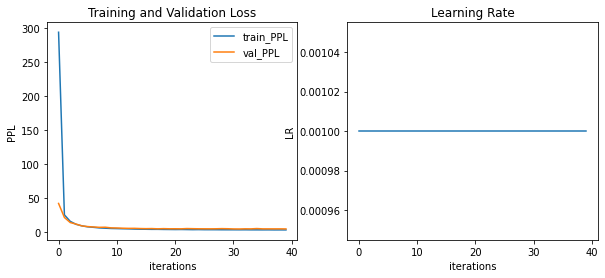

In [173]:
# Train your model 
# you can modify the codes in this block
history = {'train_PPL':[], 'val_PPL':[], 'lr':[]}

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_dataloader, optimizer, loss_fn, 1)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model.decoder.t=0
            torch.save(model.state_dict(), 'lstm-attn-model.pt')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        history['train_PPL'].append(math.exp(train_loss))
        history['val_PPL'].append(math.exp(valid_loss))
        history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history) 

In [175]:
# Test your model
torch.save(model.state_dict(), 'lstm-attn-model.pt') 
loaded_model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
loaded_model.load_state_dict(torch.load('lstm-attn-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {valid_loss:.3f} |  Test. PPL: {math.exp(valid_loss):7.3f}')

<ipython-input-169-671b60b9b4b5>:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(output)


	 Test. Loss: 1.595 |  Test. PPL:   4.930


[Hyper Parameter]
- Learning rate을 크게 하면 너무 빨리 수렴함과 동시에 이후의 학습에서는 loss가 나아지지 않거나 크게 변동하는 현상이 발생하였다. 따라서 보다 작은 값인 0.001로 설정하였다.
- Dropout 역시 0.1~0.4 구간보다 0.5를 설정하였을 때 학습이 꾸준히 이루어짐을 발견하였다.
- valid_every는 1로 설정하여 매 epoch마다 val loss를 확인하도록 하였다.


[Test Result]
- Training loss가 epoch이 지남에 따라 감소하는데, Validation loss 역시 서서히 감소하였고, 최종 val_PPL이 과제의 기준치인 7 이내에 도달하였다.
- 따라서 Overfitting이 발생했다고 보기는 힘들 것 같다.

## [Bonus] Implement GRU Seq2Seq Model

In [ ]:
'''
Q2 - (d)
Change the modules(encoder, decoder) in Seq2Seq model to GRU, and repeat (a)~(c).

'''

In [176]:
class GRUEncoder(nn.Module):
    def __init__(self, in_dim, emb_dim, hid_dim):
        super(GRUEncoder, self).__init__()
        ################### YOUR CODE ###################
        self.embedding = nn.Embedding(in_dim, emb_dim)
        self.gru = nn.GRU(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)
        #################################################

    def forward(self, input, hidden):
        ################### YOUR CODE ###################
        input = self.embedding(input).to(device)
        hiddens, hidden = self.gru(input, hidden)
        return hiddens
        #################################################

In [177]:
class AttnGRUDecoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        super(AttnGRUDecoder, self).__init__()
        ################### YOUR CODE ###################
        self.enc_hiddens = enc_hiddens
        self.dropout = dropout
        self.out_dim = out_dim
        self.fc = nn.Linear(hid_dim + hid_dim, hid_dim)
        self.tanh = nn.Tanh()
        self.embedding = nn.Embedding(out_dim, emb_dim)
        self.gru = nn.GRU(input_size=emb_dim, hidden_size=hid_dim, batch_first=True)
        self.classifier = nn.Linear(hid_dim, out_dim)
        #################################################

    def forward(self, input, hidden):

        ################### YOUR CODE ###################
        query = hidden # set query to calculate attention
        key = self.enc_hiddens.permute(1,0,2)
        value = self.enc_hiddens.permute(1,0,2)
        
        input = self.embedding(input)
        input = nn.Dropout(self.dropout)(input)

        attn_score = torch.matmul(key, query.permute(0,2,1))
        attn_coefficient = F.softmax(attn_score, dim=1)
        weighted_kv = (value * attn_coefficient)
        attn_value = torch.sum(weighted_kv, dim=1)

        hidden_concat = torch.cat([query, attn_value.unsqueeze(1)], dim=2)
        hidden_concat = self.fc(hidden_concat)
        hidden_concat = self.tanh(hidden_concat)
        hidden_concat = hidden_concat.permute(1,0,2)

        output, (h) = self.gru(input, (hidden_concat))
        output = self.classifier(output)
        output = F.log_softmax(output)

        return output, h
        #################################################

In [178]:
class GRUSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(GRUSeq2Seq, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = nn.Dropout(dropout)
        self.encoder = GRUEncoder(in_dim, emb_dim, hid_dim)
        self.decoder = AttnGRUDecoder(emb_dim, hid_dim, out_dim, dropout)
        
    def forward(self, src, trg):
        batch_size, mx_len = src.shape
        device = self.device
        ################### YOUR CODE ###################
        # Encoder
        h_e = torch.zeros(1, batch_size, self.hid_dim).to(self.device)
        hiddens = self.encoder(src, h_e).permute(1,0,2)

        # Decoder
        self.decoder.enc_hiddens = hiddens # set encoder's hidden states
        outputs = torch.zeros(mx_len, batch_size, dataset.output_lang.n_words).to(self.device) # to store each decoder's output
        h_d = hiddens[-1].unsqueeze(1).to(self.device)
        trg = trg.permute(1,0)
        for t in range(1, mx_len): # for each t'th token, get decoder outputs
            input = trg[t].unsqueeze(1)
            output, h = self.decoder(input, h_d)
            h_d = h.permute(1,0,2)
            outputs[t] = output.squeeze(1)
  
        return outputs.permute(1,2,0)
        #################################################

In [179]:
# experiment various methods for better performance
# you can modify the codes in this block
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words

hid_dim = 128
emb_dim = 64
dropout = 0.5
learning_rate=0.001
N_EPOCHS = 40
valid_every=1
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_model = GRUSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

optimizer = torch.optim.AdamW(gru_model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.output_lang_pad) 

<ipython-input-177-62e0206e5d3a>:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(output)


Epoch: 01
	Train Loss: 5.488 | Train PPL: 241.768
	 Val. Loss: 3.660 |  Val. PPL:  38.869
Epoch: 02
	Train Loss: 3.286 | Train PPL:  26.732
	 Val. Loss: 3.173 |  Val. PPL:  23.871
Epoch: 03
	Train Loss: 2.750 | Train PPL:  15.644
	 Val. Loss: 2.708 |  Val. PPL:  15.002
Epoch: 04
	Train Loss: 2.514 | Train PPL:  12.360
	 Val. Loss: 2.521 |  Val. PPL:  12.441
Epoch: 05
	Train Loss: 2.221 | Train PPL:   9.217
	 Val. Loss: 2.499 |  Val. PPL:  12.166
Epoch: 06
	Train Loss: 2.176 | Train PPL:   8.813
	 Val. Loss: 2.207 |  Val. PPL:   9.089
Epoch: 07
	Train Loss: 1.978 | Train PPL:   7.227
	 Val. Loss: 2.062 |  Val. PPL:   7.863
Epoch: 08
	Train Loss: 1.850 | Train PPL:   6.361
	 Val. Loss: 2.004 |  Val. PPL:   7.417
Epoch: 09
	Train Loss: 1.756 | Train PPL:   5.787
	 Val. Loss: 1.914 |  Val. PPL:   6.782
Epoch: 10
	Train Loss: 1.692 | Train PPL:   5.432
	 Val. Loss: 1.882 |  Val. PPL:   6.564
Epoch: 11
	Train Loss: 1.644 | Train PPL:   5.174
	 Val. Loss: 1.826 |  Val. PPL:   6.209
Epoch: 12


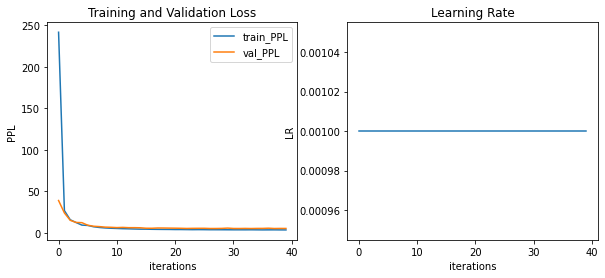

In [180]:
# Train your model 
# you can modify the codes in this block
history = {'train_PPL':[], 'val_PPL':[], 'lr':[]}

for epoch in range(N_EPOCHS):
    train_loss = train(gru_model, train_dataloader, optimizer, loss_fn, 1)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(gru_model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            gru_model.decoder.t=0
            torch.save(gru_model.state_dict(), 'gru-attn-model.pt')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        history['train_PPL'].append(math.exp(train_loss))
        history['val_PPL'].append(math.exp(valid_loss))
        history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history) 

In [182]:
# Test your model
torch.save(gru_model.state_dict(), 'gru-attn-model.pt') 
loaded_model = GRUSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
gru_model.load_state_dict(torch.load('gru-attn-model.pt'))

test_loss = evaluate(gru_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {valid_loss:.3f} |  Test. PPL: {math.exp(valid_loss):7.3f}')

<ipython-input-177-62e0206e5d3a>:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(output)


	 Test. Loss: 1.644 |  Test. PPL:   5.177


# 2. Seq2Seq model with Transformer

## Implement Transformer Seq2Seq Model

In [137]:
class TransEncoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, ff_dim, dropout, device, max_length = MAX_LENGTH):
        super().__init__()
        self.hid_dim = hid_dim
        self.max_length = max_length
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        encoder_layer = TransformerEncoderLayer(hid_dim, n_heads, ff_dim, dropout, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, n_layers)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor([hid_dim], device = device, dtype=torch.float32))
        
    def forward(self, src, pos_emb, src_mask):
        '''
        Q3 - (c)
        Implement forward method of TransEncoder Module
        (Use torch.nn.TransformerEncoder, torch.nn.TransformerEncoderLayer)
        
        INPUT
        - src: source language batched data (B, max_len)
        - pos_emb: positional embedding (1, max_len, hid_dim)
        - src_mask: padding mask tensor for source sentences (B, max_len)

        OUTPUT
        What to be returned depends on your implementation of TransSeq2Seq.
        Feel free to return outputs you need.
        Some examples below,

        - encoder output (B, max_len, hid_dim)
        '''
        #################### YOUR CODE ####################
        src = self.tok_embedding(src)
        src = self.dropout((src*self.scale) + pos_emb)
        
        output = self.encoder(src, src_key_padding_mask=src_mask)
        
        return output
        ###################################################
        

In [138]:
class TransDecoder(nn.Module):
    def __init__(self, out_dim, hid_dim, n_layers, n_heads, ff_dim, dropout, device, max_length = MAX_LENGTH):
        super().__init__()
        self.hid_dim = hid_dim
        self.max_length = max_length
        self.tok_embedding = nn.Embedding(out_dim, hid_dim)
        decoder_layer = TransformerDecoderLayer(hid_dim, n_heads, ff_dim, dropout, batch_first=True)
        self.decoder = TransformerDecoder(decoder_layer, n_layers)
        self.fc_out = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor([hid_dim], device = device, dtype=torch.float32))
        
    def forward(self, trg, pos_emb, enc_src, trg_mask, trg_sub_mask, src_mask):
        '''
        Q3 - (c)
        Implement forward method of TransDecoder Module
        (Use torch.nn.TransformerDecoder, torch.nn.TransformerDecoderLayer)
        
        INPUT
        - trg: target language batched data (B, max_len)
        - pos_emb: positional embedding (1, max_len, hid_dim)
        - enc_src: encoder outputs (B, max_len, hid_dim)
        - trg_mask: padding mask tensor for target sentences (B, max_len)
        - trg_sub_mask: subsequent mask for target sentences (max_len, max_len)
        - src_mask: padding mask tensor for source sentences (B, max_len)

        OUTPUT
        What to be returned depends on your implementation of TransSeq2Seq.
        Feel free to return outputs you need.
        Some examples below,

        - decoder output (B, max_len, out_dim)
        '''
        #################### YOUR CODE ####################
        trg = self.tok_embedding(trg)
        trg = self.dropout((trg*self.scale) + pos_emb)
        dec = self.decoder(tgt=trg, tgt_key_padding_mask=trg_mask, 
                           tgt_mask=trg_sub_mask, memory=enc_src, memory_key_padding_mask=src_mask)
        output = self.fc_out(dec).to(DEVICE)
        return output
        ###################################################

In [139]:
class TransSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout_p, device, max_length=MAX_LENGTH):
        super().__init__()
        
        self.device = device
        self.hid_dim = hid_dim
        self.max_length = max_length

        self.encoder = TransEncoder(in_dim, hid_dim, n_layers[0], n_heads, ff_dim, dropout_p, device)
        self.decoder = TransDecoder(out_dim, hid_dim, n_layers[1], n_heads, ff_dim, dropout_p, device)
        
    def make_src_mask(self, src):
        '''
        Q3 - (b)
        Implement mask generating function
        
        INPUT
        - src: batched input sentences (B, max_len)

        OUTPUT
        - Boolean padding mask tensor (B, max_len)
        '''
        #################### YOUR CODE ####################
        source_mask = (src == dataset.input_lang_pad)
        return source_mask.to(DEVICE)
        ###################################################

    def make_trg_mask(self, trg):
        '''
        Q3 - (b)
        Implement mask generating function

        INPUT
        - trg: batched target sentences (B, max_len)

        OUTPUT
        - A tuple of a padding mask tensor and a subsequent mask tensor ((B, max_len), (max_len, max_len))
        '''
        #################### YOUR CODE ####################
        trg_mask = (trg == dataset.output_lang_pad).to(DEVICE)
        trg_sub_mask = torch.logical_not(torch.tril(torch.ones((self.max_length, self.max_length))).bool()).to(DEVICE)
        return trg_mask, trg_sub_mask
        ###################################################

    def forward(self, src, trg):
        '''
        Q3 - (c)
        Implement forward method of TransSeq2Seq Module
        
        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        - decoder output (B, out_dim, max_dim)
        
        '''
        #################### YOUR CODE ####################
        src_mask = self.make_src_mask(src)
        trg_mask, trg_sub_mask = self.make_trg_mask(trg)
        
        enc_output = self.encoder(src, self.get_pos_emb(), src_mask).to(DEVICE)
        dec_output = self.decoder(trg, self.get_pos_emb(), 
                                  enc_output, trg_mask, trg_sub_mask, src_mask).to(DEVICE)
        dec_output = dec_output.permute(0,2,1)

        return dec_output.to(DEVICE)
        ###################################################  
    
    def get_pos_emb(self):
        '''
        Q3 - (a)
        Implement absolute positional embedding

        OUTPUT
        - positional embedding tensor (max_len, hid_dim)
        '''
        #################### YOUR CODE ####################
        pos_emb = torch.zeros(self.max_length, self.hid_dim)
        for p in range(self.max_length):
          for i in range(self.hid_dim):
            if i % 2 == 0:
              pos_emb[p,i] = math.sin(p / 10000 ** (2 * i) / self.hid_dim)
            else:
              pos_emb[p,i] = math.cos(p / 10000 ** (2 * i) / self.hid_dim)
        return pos_emb.to(DEVICE)
        ###################################################

## Training

In [140]:
'''
Q3 - (d)
Train your Seq2Seq model and plot perplexities and learning rates. 
Upon successful training, the test perplexity should be less than 2. 
Briefly report your hyperparmeters and results on test dataset. 
Make sure your results are printed in your submitted file.
'''

'\nQ3 - (d)\nTrain your Seq2Seq model and plot perplexities and learning rates. \nUpon successful training, the test perplexity should be less than 2. \nBriefly report your hyperparmeters and results on test dataset. \nMake sure your results are printed in your submitted file.\n'

In [141]:
# experiment various methods for better performance
# you can modify the codes in this block
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 64
ff_dim = 128
n_enc_layers = 4
n_dec_layers = 4
n_layers = [n_enc_layers, n_dec_layers]
n_heads = 8
dropout = 0.5

learning_rate=0.001
N_EPOCHS = 30
valid_every=2
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trans_model = TransSeq2Seq(in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout, device).to(device)
optimizer = torch.optim.Adam(trans_model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.output_lang_pad)

Epoch: 01
	Train Loss: 4.400 | Train PPL:  81.433
	 Val. Loss: 2.299 |  Val. PPL:   9.968
Epoch: 02
	Train Loss: 2.203 | Train PPL:   9.055
Epoch: 03
	Train Loss: 1.560 | Train PPL:   4.760
	 Val. Loss: 1.063 |  Val. PPL:   2.896
Epoch: 04
	Train Loss: 1.193 | Train PPL:   3.299
Epoch: 05
	Train Loss: 0.940 | Train PPL:   2.559
	 Val. Loss: 0.623 |  Val. PPL:   1.865
Epoch: 06
	Train Loss: 0.745 | Train PPL:   2.107
Epoch: 07
	Train Loss: 0.601 | Train PPL:   1.823
	 Val. Loss: 0.409 |  Val. PPL:   1.505
Epoch: 08
	Train Loss: 0.484 | Train PPL:   1.623
Epoch: 09
	Train Loss: 0.396 | Train PPL:   1.486
	 Val. Loss: 0.294 |  Val. PPL:   1.342
Epoch: 10
	Train Loss: 0.323 | Train PPL:   1.381
Epoch: 11
	Train Loss: 0.268 | Train PPL:   1.307
	 Val. Loss: 0.236 |  Val. PPL:   1.266
Epoch: 12
	Train Loss: 0.220 | Train PPL:   1.246
Epoch: 13
	Train Loss: 0.185 | Train PPL:   1.203
	 Val. Loss: 0.203 |  Val. PPL:   1.225
Epoch: 14
	Train Loss: 0.155 | Train PPL:   1.168
Epoch: 15
	Train Los

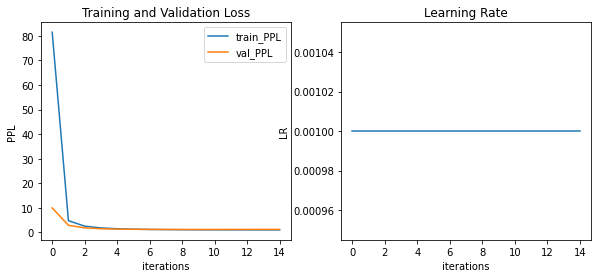

In [142]:
# Train your model
# you can modify the codes in this block
history = {'train_PPL':[], 'val_PPL':[], 'lr':[]}

for epoch in range(N_EPOCHS):
    train_loss = train(trans_model, train_dataloader, optimizer, loss_fn, 1)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(trans_model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            trans_model.decoder.t=0
            torch.save(trans_model.state_dict(), 'transformer-model.pt')

        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        history['train_PPL'].append(math.exp(train_loss))
        history['val_PPL'].append(math.exp(valid_loss))
        history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history)

In [143]:
# Test your model
torch.save(trans_model.state_dict(), 'transformer-model.pt') 
loaded_model = TransSeq2Seq(in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout, device).to(device)
loaded_model.load_state_dict(torch.load('transformer-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {valid_loss:.3f} |  Test. PPL: {math.exp(valid_loss):7.3f}')

	 Test. Loss: 0.209 |  Test. PPL:   1.233


[Hyper Parameter]
- LSTM의 경우와 마찬가지로, dropout은 낮은 값보다 0.5 수준에서 학습이 가장 꾸준히 진행되는 모습을 보였다.
- learning rate 역시 0.001인 경우에 가장 performance가 좋고 학습이 잘 되었다.
- 그 외의 hyper parameter들은 여러 경우를 돌려보며 최종적으로 결정하였다.

[Test Result]
- Train/Validation loss 모두 epoch이 지남에 따라 감소하였고, Validation loss가 증가하는 추세가 보이지 않아 overfitting이 발생했다고 보기 어렵다.
- test perplexity는 1.233으로, 앞선 두 모델보다 낮게 나타났다.

[Which Approach is Better & Why?]
- 결론적으로 앞선 LSTM, GRU 모델보다 Transformer를 활용한 모델의 결과가 더 좋게 나타났다.
- 앞선 두 모델들은 test perplexity가 5에 가까웠던 반면, Transformer 모델은 총 epoch이 30이었음에도 1에 근사한 test perplexity를 보여주었다.
- 그 이유 중 첫번째는 LSTM과 GRU가 "이전의 정보를 잘 기억하지 못한다"는 기존 RNN의 문제점을 어느 정도 해결하였지만 완벽히 해결하지는 못했기 때문으로 볼 수 있다. 물론 본 과제는 LSTM, GRU에 Attention을 사용하여 이를 보완하였다.
- 그 다음으로는, Transformer는 Multi-head Attention, Encoder에서의 self-attention, Decoder에서 Encoder의 hidden states 정보를 활용한 attention 등을 통해 중요한 정보에 더 많이 집중할 수 있다는 장점이 있기 때문일 것이다.